In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import datetime as dt

import warnings
warnings.filterwarnings("ignore")

### 1. Load data

In [3]:
test_result = pd.read_csv('/Users/ChunyanHao/Desktop/GitHub/DS_Take_Home/data/Pricing_Test/test_results.csv')
users = pd.read_csv('/Users/ChunyanHao/Desktop/GitHub/DS_Take_Home/data/Pricing_Test/user_table.csv')

In [4]:
test_result['timestamp'] = pd.to_datetime(test_result['timestamp'].str[:10])

In [5]:
test_result.head(3)

,user_id,timestamp,source,device,operative_system,test,price,converted
0,604839,2015-05-08,ads_facebook,mobile,iOS,0,39,0
1,624057,2015-05-10,seo-google,mobile,android,0,39,0
2,317970,2015-04-04,ads-bing,mobile,android,0,39,0


In [6]:
users.head(3)

,user_id,city,country,lat,long
0,510335,Peabody,USA,42.53,-70.97
1,89568,Reno,USA,39.54,-119.82
2,434134,Rialto,USA,34.11,-117.39


In [7]:
test_result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316800 entries, 0 to 316799
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   user_id           316800 non-null  int64         
 1   timestamp         316800 non-null  datetime64[ns]
 2   source            316800 non-null  object        
 3   device            316800 non-null  object        
 4   operative_system  316800 non-null  object        
 5   test              316800 non-null  int64         
 6   price             316800 non-null  int64         
 7   converted         316800 non-null  int64         
dtypes: datetime64[ns](1), int64(4), object(3)
memory usage: 19.3+ MB


In [8]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 275616 entries, 0 to 275615
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   user_id  275616 non-null  int64  
 1   city     275616 non-null  object 
 2   country  275616 non-null  object 
 3   lat      275616 non-null  float64
 4   long     275616 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 10.5+ MB


In [9]:
for column in test_result.columns:
    uniques = test_result[column].unique()
    print('{0:20s} {1:5d}\t'.format(column, len(uniques)), uniques[:5])

user_id              316800	 [604839 624057 317970 685636 820854]
timestamp               91	 ['2015-05-08T00:00:00.000000000' '2015-05-10T00:00:00.000000000'
 '2015-04-04T00:00:00.000000000' '2015-05-07T00:00:00.000000000'
 '2015-05-24T00:00:00.000000000']
source                  12	 ['ads_facebook' 'seo-google' 'ads-bing' 'direct_traffic' 'ads-google']
device                   2	 ['mobile' 'web']
operative_system         6	 ['iOS' 'android' 'mac' 'windows' 'other']
test                     2	 [0 1]
price                    2	 [39 59]
converted                2	 [0 1]


In [10]:
for column in users.columns:
    uniques = users[column].unique()
    print('{0:20s} {1:5d}\t'.format(column, len(uniques)), uniques[:5])

user_id              275616	 [510335  89568 434134 289769 939586]
city                   923	 ['Peabody' 'Reno' 'Rialto' 'Carson City' 'Chicago']
country                  1	 ['USA']
lat                    713	 [42.53 39.54 34.11 39.15 41.84]
long                   830	 [ -70.97 -119.82 -117.39 -119.74  -87.68]


In [11]:
test_data = test_result.merge(users, on = 'user_id', how = 'left')

In [12]:
test_data.head(2)

,user_id,timestamp,source,device,operative_system,test,price,converted,city,country,lat,long
0,604839,2015-05-08,ads_facebook,mobile,iOS,0,39,0,Buffalo,USA,42.89,-78.86
1,624057,2015-05-10,seo-google,mobile,android,0,39,0,Lakeville,USA,44.68,-93.24


### 2. Calculate convert rate

In [13]:
test_data[['test', 'price', 'converted', 'user_id']].groupby(['test', 'price', 'converted'])['user_id'].count().reset_index()

,test,price,converted,user_id
0,0,39,0,198487
1,0,39,1,4030
2,0,59,0,205
3,0,59,1,5
4,1,39,0,154
5,1,39,1,1
6,1,59,0,112146
7,1,59,1,1772


We notice that there are a small pert of records in control group by with the price of 59, also some records in test group but with the price of 39.

Therefore we need to first drop these abnormal records.

In [14]:
test_data = test_data[(test_data['test'] == 0) & (test_data['price'] == 39)|
                     (test_data['test'] == 1) & (test_data['price'] == 59)] 

In [15]:
test_data[['test', 'price', 'converted', 'user_id']].groupby(['test', 'price', 'converted'])['user_id'].count().reset_index()

,test,price,converted,user_id
0,0,39,0,198487
1,0,39,1,4030
2,1,59,0,112146
3,1,59,1,1772


In [16]:
test_data[['test', 'price', 'converted']].groupby(['test', 'price'])['converted'].mean().reset_index()

,test,price,converted
0,0,39,0.019900
1,1,59,0.015555


We notice that the conversion_rate in test group is 0.44% lower than the control group. 

However, the average revenue of the test group : 59*(1772)/(1772 + 112146) = 0.918 is greater than the control group 39*(4030)/(4030 + 198487) = 0.776, which means that a higher price can bring a higher revenue from each user.

### 3. Data visualization

Before we get the final conclusion, we need to confirm that the sample distribution between the control and test group are random among other features.

In other words, the only difference between test and control group is price

#### 3.1 Data distribution check

<AxesSubplot:xlabel='source', ylabel='pct'>

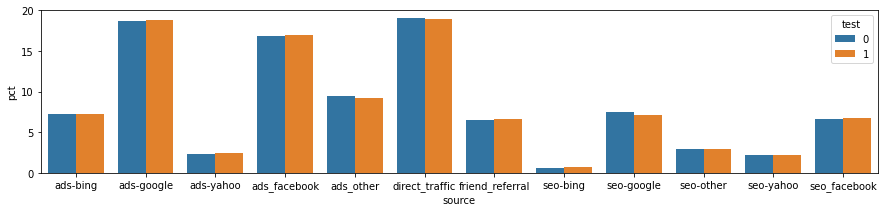

In [17]:
total = test_data[['user_id','test']].groupby(['test']).count().reset_index()
temp = test_data[['user_id', 'source', 'test']].groupby(['source', 'test']).count().reset_index()
temp = pd.merge(left = temp, right = total, how = 'left', left_on = 'test', right_on = 'test')
temp['pct'] = 100*temp['user_id_x']/temp['user_id_y']
temp = temp.iloc[:,[0,1,4]]

fig, ax = plt.subplots(figsize =(15, 3))
sns.barplot(data = temp, x = 'source', y = 'pct', hue = 'test')

<AxesSubplot:xlabel='device', ylabel='pct'>

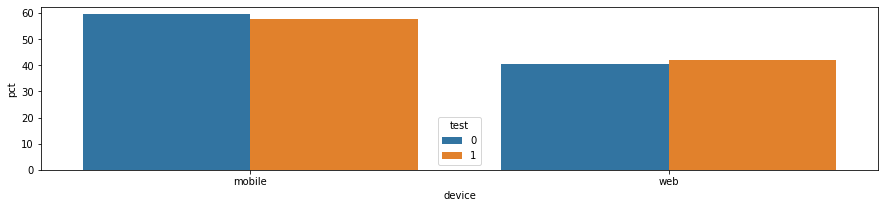

In [18]:
temp = test_data[['user_id', 'device', 'test']].groupby(['device', 'test']).count().reset_index()
temp = pd.merge(left = temp, right = total, how = 'left', left_on = 'test', right_on = 'test')
temp['pct'] = 100*temp['user_id_x']/temp['user_id_y']
temp = temp.iloc[:,[0,1,4]]

fig, ax = plt.subplots(figsize =(15, 3))
sns.barplot(data = temp, x = 'device', y = 'pct', hue = 'test')

<AxesSubplot:xlabel='operative_system', ylabel='pct'>

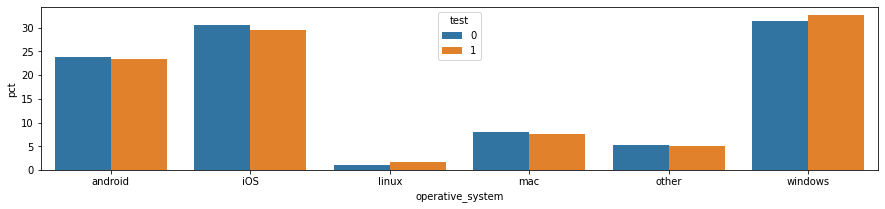

In [19]:
temp = test_data[['user_id', 'operative_system', 'test']].groupby(['operative_system', 'test']).count().reset_index()
temp = pd.merge(left = temp, right = total, how = 'left', left_on = 'test', right_on = 'test')
temp['pct'] = 100*temp['user_id_x']/temp['user_id_y']
temp = temp.iloc[:,[0,1,4]]

fig, ax = plt.subplots(figsize =(15, 3))
sns.barplot(data = temp, x = 'operative_system', y = 'pct', hue = 'test')

The distribution above show that the distribution of sample data in test and control group are similar. We can take further steps of analysis.

#### 3.2 Conversion rate check

We can then use A/B test to verify if the conversion rate difference between control and test group are significant:

H0: There is no significant difference in conversion rate between test and control group
H1: The difference in conversion rate between test and control group is significant.

In [20]:
from scipy.stats import ttest_ind
ctr_val = test_data[test_data['test'] == 0]['converted'].values
exp_val = test_data[test_data['test'] == 1]['converted'].values
print(ttest_ind(ctr_val, exp_val, axis=0, equal_var=True))

Ttest_indResult(statistic=8.744781828681587, pvalue=2.2450851601497147e-18)


In [21]:
import statsmodels.api as sm
convert_old = 4030
convert_new = 1772
n_old = 4030 + 198487
n_new = 1772 + 112146
zstat, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new])
zstat, p_value

(8.74375299250435, 2.2549214716059568e-18)

In [29]:
# We can also use the same method to run the AB test based on average revenue
ctr = test_data[test_data['test'] == 0][['converted', 'price']]
exp = test_data[test_data['test'] == 1][['converted', 'price']]

ctr_val = ctr['price']*ctr['converted'].values
exp_val = exp['price']*exp['converted'].values
print(ttest_ind(ctr_val, exp_val, axis=0, equal_var=False))

Ttest_indResult(statistic=-5.715224666463108, pvalue=1.0972577312420781e-08)


Because the corresponding P-value is extremely small, we can reject the null hypothesis and confirm that The difference in conversion rate between test and control group is significant

#### 3.3 Conversion rate vs users' behavior

We can explore the relationship between users' behavior and conversion rate through different 'source', 'device' and 'operation system' types.

Further more, it's also helpful if we can analysis the difference from test and control group:

<AxesSubplot:xlabel='source', ylabel='converted'>

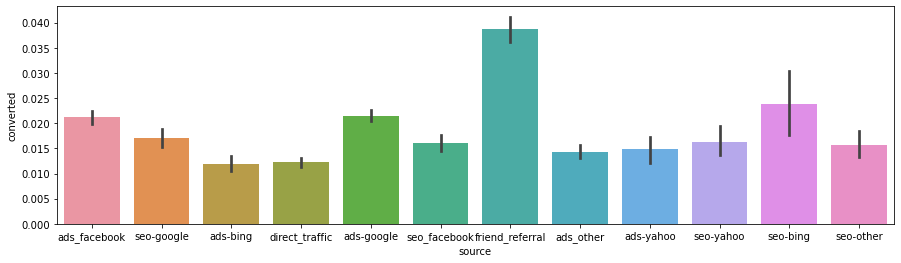

In [23]:
fig, ax = plt.subplots(figsize = (15,4))
sns.barplot(data = test_data, x = 'source', y = 'converted', estimator = np.mean)

<AxesSubplot:xlabel='source', ylabel='converted'>

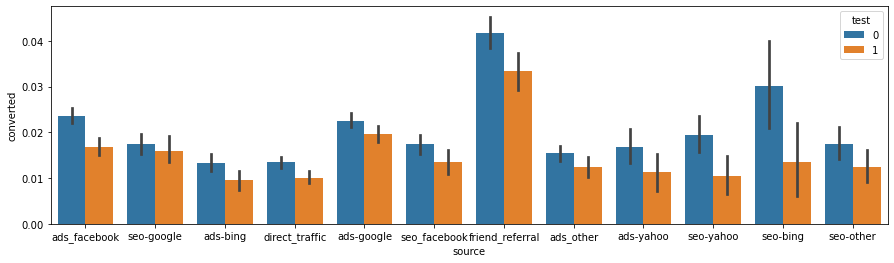

In [24]:
fig, ax = plt.subplots(figsize = (15,4))
sns.barplot(data = test_data, x = 'source', y = 'converted', hue = 'test', estimator = np.mean)

It's clear that:

1) Friend referral is the most effective way to convert visitors to buyers.

2) Google and Facebook are the two best advertisement channel.

3) Many users came to the site by clicking on search results in Bing.

4) The conversion rate all decreased significantly after price increase.

<AxesSubplot:xlabel='device', ylabel='converted'>

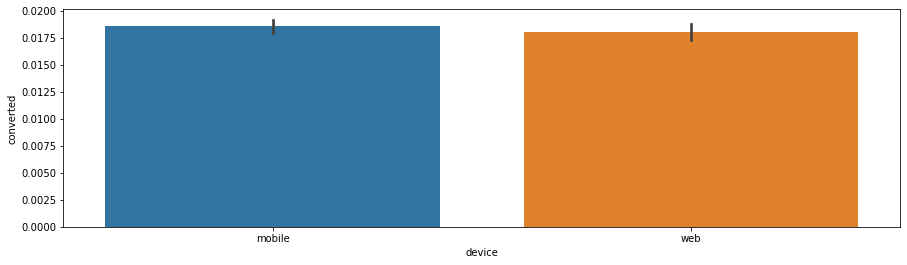

In [25]:
fig, ax = plt.subplots(figsize = (15,4))
sns.barplot(data = test_data, x = 'device', y = 'converted', estimator = np.mean)

<AxesSubplot:xlabel='device', ylabel='converted'>

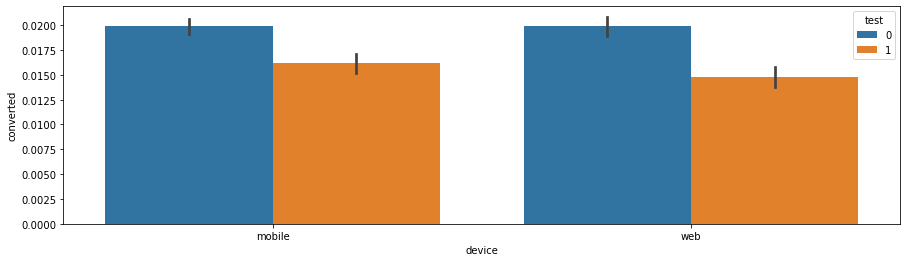

In [26]:
fig, ax = plt.subplots(figsize = (15,4))
sns.barplot(data = test_data, x = 'device', y = 'converted', hue = 'test', estimator = np.mean)

Generally speaking, there is no significant difference among conversion rate in mobile and web users. 

<AxesSubplot:xlabel='operative_system', ylabel='converted'>

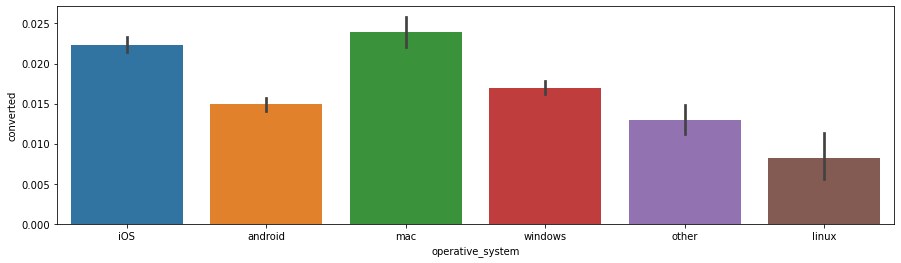

In [27]:
fig, ax = plt.subplots(figsize = (15,4))
sns.barplot(data = test_data, x = 'operative_system', y = 'converted', estimator = np.mean)

<AxesSubplot:xlabel='operative_system', ylabel='converted'>

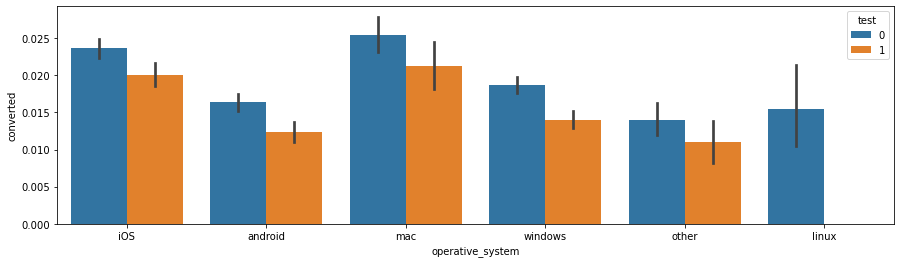

In [28]:
fig, ax = plt.subplots(figsize = (15,4))
sns.barplot(data = test_data, x = 'operative_system', y = 'converted', hue = 'test', estimator = np.mean)

The conversion rate in iOS and Mac are higher than other operation system users.

#### Bonus Question:
#### After how many days you would have stopped the test? Please, explain why.

Usually, we need to run the AB Test at least two weeks to identify the potential weekly trend. 

Meanwhile, we also need to consider the daily website user flow and effective sample size in order to make the A/B test result robust.

Beside, the cost or the potential lost of users should also be taken into account.